**El objetivo del ejercicio es:**

- Optimizar arquitectura de la red

- Sacar heatmaps

- Partir training en training + validación usando como ejemplo lo que se hacía en el notebook de las caras (carpeta 03-caras)

In [1]:
COLAB = True

Si se desea ejecutar en local:

- Descargar el dataset de training de: https://drive.google.com/file/d/1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x

- Y el de test de: https://drive.google.com/file/d/1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r

- Poner variable COLAB a False

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from glob import glob
from keras import optimizers
from keras.layers.normalization import BatchNormalization

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [4]:
!ls

sample_data


In [5]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x',
                                        dest_path='./seg_train.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r',
                                        dest_path='./seg_test.zip', unzip=True)
    

Unzipping...Done.
Unzipping...Done.


In [6]:
!ls

__MACOSX  sample_data  seg_test  seg_test.zip  seg_train  seg_train.zip


In [7]:
!ls seg_train

buildings  forest  glacier  mountain  sea  street


In [8]:

!ls seg_test

buildings  forest  glacier  mountain  sea  street


In [9]:
!ls seg_train/buildings

0.jpg	   12578.jpg  14916.jpg  17468.jpg  20017.jpg  4600.jpg  7382.jpg
10006.jpg  12590.jpg  14918.jpg  17479.jpg  20027.jpg  4620.jpg  7383.jpg
10014.jpg  125.jpg    14947.jpg  17480.jpg  2002.jpg   4621.jpg  739.jpg
10018.jpg  12602.jpg  14952.jpg  17491.jpg  20048.jpg  4623.jpg  7418.jpg
1001.jpg   12615.jpg  14958.jpg  17495.jpg  20054.jpg  4630.jpg  742.jpg
10029.jpg  12617.jpg  14968.jpg  17503.jpg  2038.jpg   4631.jpg  7439.jpg
10032.jpg  12629.jpg  14984.jpg  17516.jpg  2041.jpg   4634.jpg  7443.jpg
10056.jpg  12632.jpg  14991.jpg  1751.jpg   2043.jpg   463.jpg	 7455.jpg
1009.jpg   12636.jpg  1501.jpg	 17520.jpg  2059.jpg   4667.jpg  7463.jpg
10113.jpg  1263.jpg   15026.jpg  17537.jpg  2069.jpg   4686.jpg  7471.jpg
10126.jpg  12649.jpg  15030.jpg  17539.jpg  2076.jpg   4715.jpg  7478.jpg
1012.jpg   12659.jpg  1503.jpg	 1753.jpg   2083.jpg   4748.jpg  747.jpg
10144.jpg  12668.jpg  15042.jpg  17541.jpg  2088.jpg   4770.jpg  7491.jpg
10151.jpg  12669.jpg  15045.jpg  17545.jpg  20

In [10]:
ficheros_buildings = glob("./seg_train/buildings/*")
ficheros_forest = glob("./seg_train/forest/*")
ficheros_glacier = glob("./seg_train/glacier/*")
ficheros_mountain = glob("./seg_train/mountain/*")
ficheros_sea = glob("./seg_train/sea/*")
ficheros_street = glob("./seg_train/street/*")

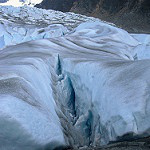

In [11]:
imagen = load_img(ficheros_glacier[7])
imagen

In [12]:
ficheros_train = ficheros_buildings + ficheros_forest + ficheros_glacier + ficheros_mountain + ficheros_sea + ficheros_street
clases_train   = ["buildings"]*len(ficheros_buildings) + ["forest"]*len(ficheros_forest) + ["glacier"]*len(ficheros_glacier) + ["mountain"]*len(ficheros_mountain) + ["sea"]*len(ficheros_sea) + ["street"]*len(ficheros_street)

In [13]:
print('files size: ', len(ficheros_train))
print('clases size: ', len(clases_train))

files size:  14034
clases size:  14034


In [14]:
ficheros_buildings = glob("./seg_test/buildings/*")
ficheros_forest = glob("./seg_test/forest/*")
ficheros_glacier = glob("./seg_test/glacier/*")
ficheros_mountain = glob("./seg_test/mountain/*")
ficheros_sea = glob("./seg_test/sea/*")
ficheros_street = glob("./seg_test/street/*")

In [15]:
ficheros_test = ficheros_buildings + ficheros_forest + ficheros_glacier + ficheros_mountain + ficheros_sea + ficheros_street
clases_test   = ["buildings"]*len(ficheros_buildings) + ["forest"]*len(ficheros_forest) + ["glacier"]*len(ficheros_glacier) + ["mountain"]*len(ficheros_mountain) + ["sea"]*len(ficheros_sea) + ["street"]*len(ficheros_street)

In [16]:
print('files size: ', len(ficheros_test))
print('clases size: ', len(clases_test))

files size:  3000
clases size:  3000


In [17]:
import pandas as pd
df_train  = pd.DataFrame({"filepath":ficheros_train, "class":clases_train})
df_train

filepath      class
0       ./seg_train/buildings/3056.jpg  buildings
1       ./seg_train/buildings/7530.jpg  buildings
2       ./seg_train/buildings/7701.jpg  buildings
3      ./seg_train/buildings/18875.jpg  buildings
4      ./seg_train/buildings/14474.jpg  buildings
...                                ...        ...
14029      ./seg_train/street/6454.jpg     street
14030     ./seg_train/street/15732.jpg     street
14031     ./seg_train/street/11289.jpg     street
14032      ./seg_train/street/6095.jpg     street
14033     ./seg_train/street/14005.jpg     street

[14034 rows x 2 columns]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(df_train['filepath'], df_train['class'], test_size=0.3, random_state=1)

In [19]:
df_train = pd.DataFrame({"filepath":X_train, "class":Y_train})
df_val = pd.DataFrame({"filepath":X_val, "class":Y_val})
df_test  = pd.DataFrame({"filepath":ficheros_test, "class":clases_test})

In [20]:
df_train.shape, df_val.shape, df_test.shape

((9823, 2), (4211, 2), (3000, 2))

In [21]:
batch_size = 16

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [22]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [23]:
normed_dims

(150, 150)

In [24]:
# Definir arquitextura del modelo:
from tensorflow.keras.applications import DenseNet201

DenseNet = DenseNet201(weights="imagenet", include_top=False, input_shape=normed_dims+(3,))
DenseNet.trainable = False
input_layer = DenseNet.layers[0]
conv1bn = DenseNet.layers[-3]
gbap = GlobalAveragePooling2D()(conv1bn.output)
dropout_1 = Dropout(0.2)(gbap)
outputs = Dense(units=6,activation="softmax", name='Capa_softmax')(dropout_1)
model = Model(inputs=input_layer.output, outputs=outputs, name="DenseNet201_rebuild")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])


74842112/74836368 [==============================] - 1s 0us/step


In [25]:
model.summary()

Model: "DenseNet201_rebuild"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________

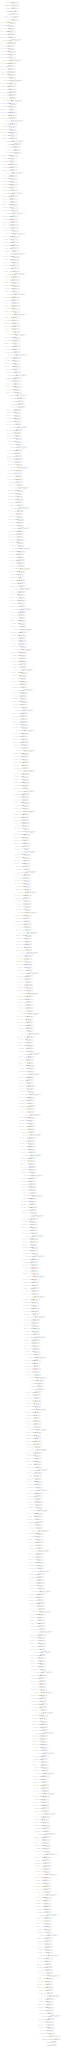

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [27]:
preprocess_input = lambda x:x/255.
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [28]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col = "filepath",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    x_col = "filepath",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col = "filepath",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 9823 validated image filenames belonging to 6 classes.
Found 4211 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [29]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [30]:
validation_generator.class_mode

'sparse'

In [31]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(9823, 4211, 3000)

In [32]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [33]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

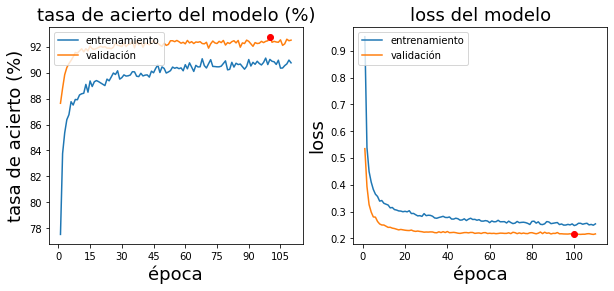

In [35]:
epochs = 10

modelpath="best_model.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [36]:
!ls -la

total 327196
drwxr-xr-x 1 root root      4096 Jan 31 16:33 .
drwxr-xr-x 1 root root      4096 Jan 31 16:28 ..
-rw-r--r-- 1 root root  75289960 Jan 31 18:52 best_model.h5
drwxr-xr-x 1 root root      4096 Jan 28 17:15 .config
drwxr-xr-x 4 root root      4096 Jan 31 16:30 __MACOSX
drwxr-xr-x 1 root root      4096 Jan 20 17:27 sample_data
drwxr-xr-x 8 root root      4096 Jan 31 16:30 seg_test
-rw-r--r-- 1 root root  45638665 Jan 31 16:30 seg_test.zip
drwxr-xr-x 8 root root      4096 Jan 31 16:30 seg_train
-rw-r--r-- 1 root root 214084517 Jan 31 16:30 seg_train.zip


In [37]:
model = load_model('/content/best_model.h5')

## **Resultados obtenidos**

In [38]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

614/614 [==============================] - 61s 96ms/step - loss: 0.2368 - accuracy: 0.9144
Train loss    : 0.23676270246505737
Train accuracy: 0.9143846035003662

264/264 [==============================] - 11s 42ms/step - loss: 0.2161 - accuracy: 0.9259
Val loss    : 0.21614280343055725
Val accuracy: 0.9259083271026611

188/188 [==============================] - 8s 43ms/step - loss: 0.2081 - accuracy: 0.9233
Test loss     : 0.2081492692232132
Test accuracy : 0.9233333468437195


In [39]:
y_real = test_generator.classes
y_pred_proba = model.predict(test_generator)

In [40]:
y_real[:5]

[0, 0, 0, 0, 0]

In [41]:
y_pred_proba[:5]

array([[9.1452014e-01, 9.1961410e-04, 2.3940507e-05, 3.4527220e-06,
        8.9554786e-05, 8.4443353e-02],
       [9.9523574e-01, 6.3659358e-09, 5.9714416e-06, 7.5473465e-05,
        2.7159191e-04, 4.4112885e-03],
       [9.9082631e-01, 2.1671713e-07, 1.1489742e-03, 1.2031898e-03,
        3.8078471e-04, 6.4404909e-03],
       [9.9999356e-01, 1.3154821e-08, 5.8764183e-08, 3.7775074e-08,
        1.1351835e-07, 6.1585451e-06],
       [6.2562965e-02, 2.0137767e-03, 8.7822311e-02, 3.5929682e-03,
        8.2654977e-01, 1.7458238e-02]], dtype=float32)

In [42]:
class_indices = test_generator.class_indices
class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [43]:
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [44]:
y_real = np.array(test_generator.classes)
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.92      0.92       437
           1       0.99      0.99      0.99       474
           2       0.87      0.86      0.86       553
           3       0.87      0.87      0.87       525
           4       0.96      0.96      0.96       510
           5       0.93      0.95      0.94       501

    accuracy                           0.92      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.92      0.92      0.92      3000



## **Visualización de ejemplos de test**

In [45]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_dataframe(
    df_test,
    x_col = "filepath",
    y_col = "class",
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='sparse')

Found 3000 validated image filenames belonging to 6 classes.


In [46]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [47]:
X_te.max()

255.0

In [48]:
test_generator2.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [49]:
y_te

array([0., 0., 0., ..., 5., 5., 5.], dtype=float32)

Clase real: forest
buildings: 0% forest: 99% glacier: 0% mountain: 0% sea: 0% street: 0% 


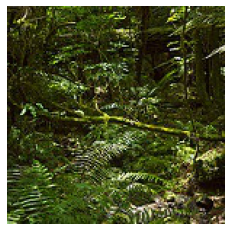

In [50]:
ind_te1 = 500

image = X_te[ind_te1].copy()

print("Clase real:", num2class[y_te[ind_te1]])
plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0]
cadena = ""
for i in range(len(num2class)):
    cadena = cadena + "{}: {}% ".format(num2class[i], int(100*p[i]))
print(cadena)

In [51]:
import tensorflow as tf
import cv2

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices['buildings']]
    print("Probabilidad clase buildings: {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices['forest']]
    print("Probabilidad clase forest : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices['glacier']]
    print("Probabilidad clase glacier: {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices['mountain']]
    print("Probabilidad clase mountain : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices['sea']]
    print("Probabilidad clase sea: {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices['street']]
    print("Probabilidad clase street: {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

In [52]:
X_te[i].max() , num2class[0]

(255.0, 'buildings')

Clase real: mountain


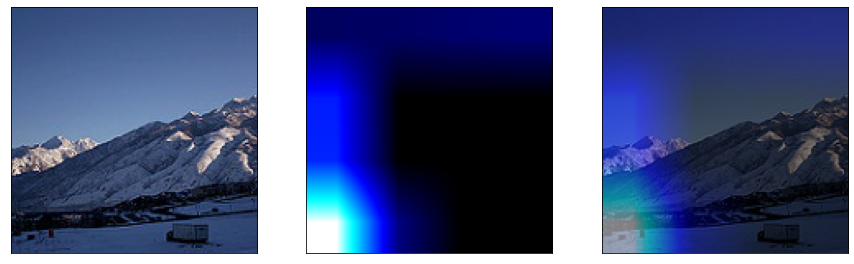

Probabilidad clase buildings: 0.0%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier: 57.1%
Probabilidad clase mountain : 42.8%
Probabilidad clase sea: 0.0%
Probabilidad clase street: 0.0%



Clase real: forest


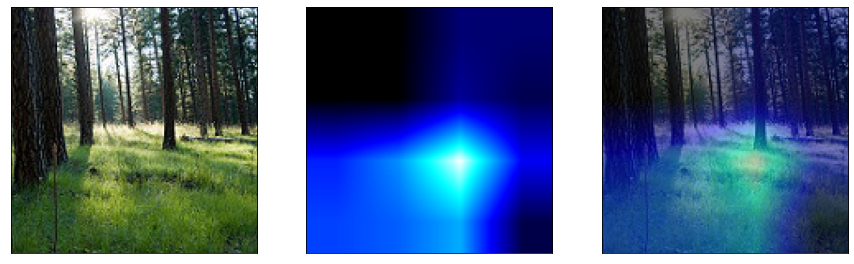

Probabilidad clase buildings: 0.0%
Probabilidad clase forest : 100.0%
Probabilidad clase glacier: 0.0%
Probabilidad clase mountain : 0.0%
Probabilidad clase sea: 0.0%
Probabilidad clase street: 0.0%



Clase real: glacier


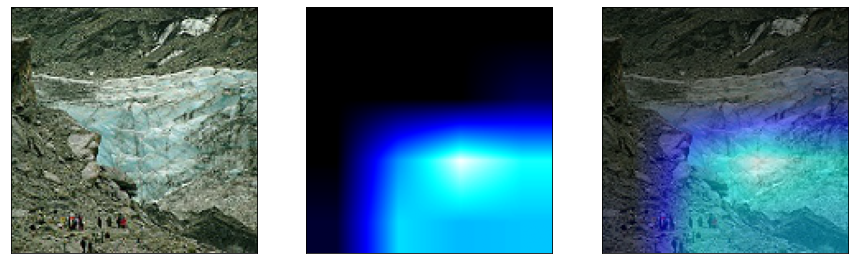

Probabilidad clase buildings: 0.0%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier: 99.6%
Probabilidad clase mountain : 0.2%
Probabilidad clase sea: 0.1%
Probabilidad clase street: 0.0%



Clase real: street


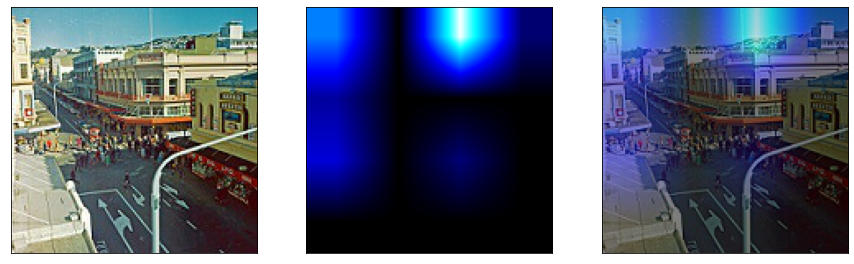

Probabilidad clase buildings: 42.6%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier: 0.0%
Probabilidad clase mountain : 0.0%
Probabilidad clase sea: 0.0%
Probabilidad clase street: 57.4%



Clase real: glacier


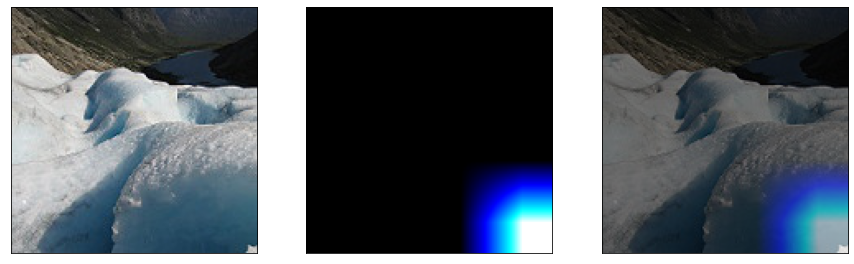

Probabilidad clase buildings: 0.0%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier: 98.9%
Probabilidad clase mountain : 1.1%
Probabilidad clase sea: 0.0%
Probabilidad clase street: 0.0%



Clase real: street


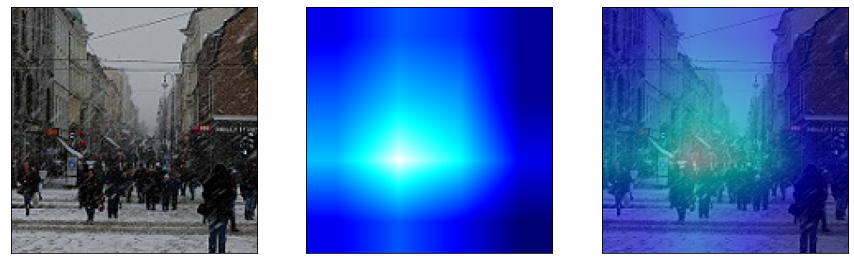

Probabilidad clase buildings: 0.4%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier: 0.1%
Probabilidad clase mountain : 0.0%
Probabilidad clase sea: 0.0%
Probabilidad clase street: 99.6%



Clase real: mountain


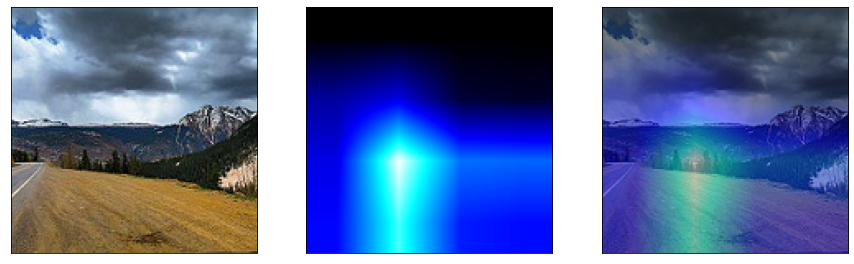

Probabilidad clase buildings: 0.1%
Probabilidad clase forest : 0.1%
Probabilidad clase glacier: 11.9%
Probabilidad clase mountain : 85.6%
Probabilidad clase sea: 0.2%
Probabilidad clase street: 2.2%



Clase real: street


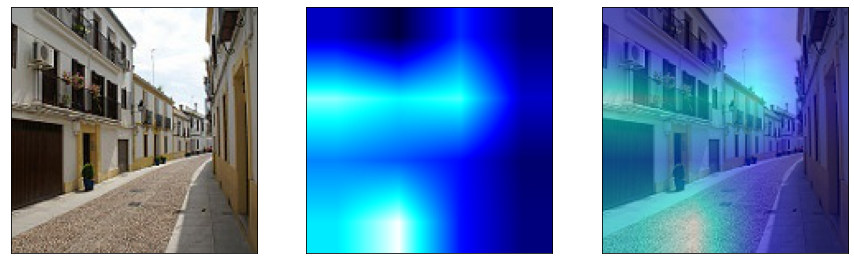

Probabilidad clase buildings: 0.8%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier: 0.0%
Probabilidad clase mountain : 0.0%
Probabilidad clase sea: 0.0%
Probabilidad clase street: 99.2%



Clase real: buildings


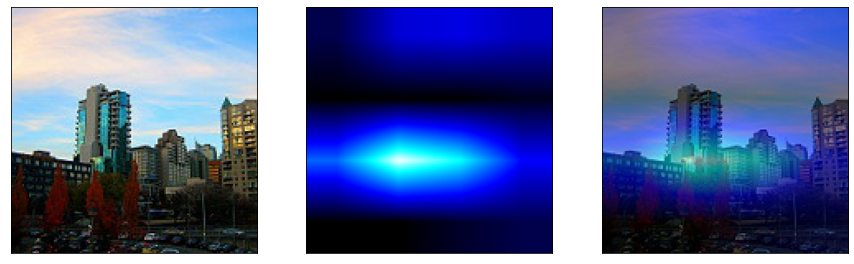

Probabilidad clase buildings: 80.4%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier: 0.1%
Probabilidad clase mountain : 5.2%
Probabilidad clase sea: 0.5%
Probabilidad clase street: 13.8%



Clase real: sea


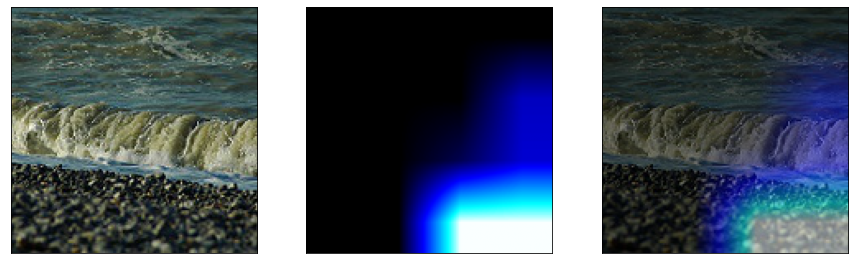

Probabilidad clase buildings: 0.0%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier: 10.2%
Probabilidad clase mountain : 0.3%
Probabilidad clase sea: 89.4%
Probabilidad clase street: 0.0%





In [53]:
ind = np.random.randint(0, 3000, size=10)

for i in ind:
    print("Clase real:", num2class[y_te[i]])
    show_heatmap(model, X_te[i]/255)

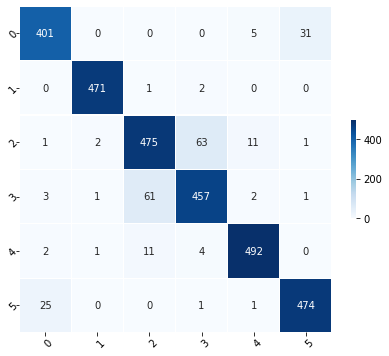

In [54]:
import copy
import seaborn as sns

x = preprocess_input(copy.deepcopy(X_te))
y_preds = model.predict(preprocess_input(copy.deepcopy(X_te)))
y_preds = np.argmax(y_preds, axis=1)
cm = confusion_matrix(y_real, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()